In [1]:
# import relevant packages
from db_queries import get_outputs, get_ids
import pandas as pd
import numpy as np
from gbd_mapping import causes, risk_factors
from vivarium_inputs import get_measure
import gbd_mapping, vivarium_inputs, scipy.stats
from operator import attrgetter
from get_draws.api import get_draws
from math import sqrt, pi
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
# these are the age groups and locations relevant to the anemia portion of the 
# large scale food fortification simulation project

# Note - additional validation required for other populations

locations = [163,214,179]
ages = [4,5]

In [66]:
# get global anemia impairment prevalence 
anemia = get_draws('rei_id', 192, source='como', measure_id=5, location_id=locations,
                   age_group_id=ages, year_id=2017, gbd_round_id=5)
anemia_all = anemia.where(anemia['cause_id'] == 294).dropna()
anemia_avg = anemia_all.set_index(['age_group_id','location_id', 'measure_id', 'rei_id',
                                 'sex_id', 'year_id', 'metric_id','cause_id'])
anemia_avg['avg'] = anemia_avg.mean(axis=1)
anemia_avg = anemia_avg.reset_index()
gbd_prepped = anemia_avg[['location_id','age_group_id','sex_id','avg']]
gbd_prepped = gbd_prepped.rename(columns={'avg': 'prev'})
gbd_prepped.head()

,location_id,age_group_id,sex_id,prev
0,163.0,4.0,1.0,0.711160
1,163.0,5.0,1.0,0.579284
2,163.0,4.0,2.0,0.632275
3,163.0,5.0,2.0,0.580276
4,179.0,4.0,1.0,0.813641


In [ ]:
# define lists of anemia sequela by severity
mild = [144, 172, 177, 182, 206, 240, 438, 442, 525, 531, 537, 645, 648, 651, 654, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1057, 1061, 1065, 1069, 1079, 1089, 1099, 1106, 1120, 1361, 1373, 1385, 1397, 1409, 1421, 1433, 1445, 4952, 4955, 4976, 4985, 4988, 5009, 5018, 5027, 5036, 5051, 5063, 5075, 5087, 5099, 5111, 5123, 5225, 5228, 5249, 5252, 5273, 5276, 5393, 5567, 5579, 5606, 5627, 5648, 5651, 5654, 5678, 5699, 5702, 5705, 7202, 7214, 22989, 22990, 22991, 22992, 22993, 23030, 23034, 23038, 23042, 23046]
moderate = [145, 173, 178, 183, 207, 241, 439, 443, 526, 532, 538, 646, 649, 652, 655, 1005, 1009, 1013, 1017, 1021, 1025, 1029, 1033, 1058, 1062, 1066, 1070, 1080, 1090, 1100, 1107, 1121, 1364, 1376, 1388, 1400, 1412, 1424, 1436, 1448, 4958, 4961, 4979, 4991, 4994, 5012, 5021, 5030, 5039, 5054, 5066, 5078, 5090, 5102, 5114, 5126, 5219, 5222, 5243, 5246, 5267, 5270, 5396, 5570, 5582, 5609, 5630, 5657, 5660, 5663, 5681, 5708, 5711, 5714, 7205, 7217, 22999, 23000, 23001, 23002, 23003, 23031, 23035, 23039, 23043, 23047]
severe = [146, 174, 179, 184, 208, 242, 440, 444, 527, 533, 539, 647, 650, 653, 656, 1006, 1010, 1014, 1018, 1022, 1026, 1030, 1034, 1059, 1060, 1063, 1064, 1067, 1068, 1071, 1074, 1075, 1077, 1081, 1083, 1085, 1087, 1091, 1093, 1095, 1097, 1101, 1108, 1122, 1367, 1379, 1391, 1403, 1415, 1427, 1439, 1451, 4964, 4967, 4982, 4997, 5000, 5015, 5024, 5033, 5042, 5057, 5069, 5081, 5093, 5105, 5117, 5129, 5213, 5216, 5237, 5240, 5261, 5264, 5399, 5573, 5585, 5612, 5633, 5666, 5669, 5672, 5684, 5717, 5720, 5723, 7208, 7220, 23009, 23010, 23011, 23012, 23013, 23032, 23036, 23040, 23044, 23048]
total = mild+moderate+severe

# aggregate severity-specific anemia prevalence from sequela lists
total_anemia = get_outputs(location_id=locations, age_group_id=ages, year_id=2017,
                         gbd_round_id=5, topic='sequela', sequela_id=total,
                         measure_id=5, metric_id=3, sex_id=[1,2])
total_anemia = total_anemia.groupby(['location_id','age_group_id','sex_id'], as_index=False).sum()
mild_anemia = get_outputs(location_id=locations, age_group_id=ages, year_id=2017,
                         gbd_round_id=5, topic='sequela', sequela_id=mild,
                         measure_id=5, metric_id=3, sex_id=[1,2])
mild_anemia = mild_anemia.groupby(['location_id','age_group_id','sex_id'], as_index=False).sum()
moderate_anemia = get_outputs(location_id=locations, age_group_id=ages, year_id=2017,
                         gbd_round_id=5, topic='sequela', sequela_id=moderate,
                         measure_id=5, metric_id=3, sex_id=[1,2])
moderate_anemia = moderate_anemia.groupby(['location_id','age_group_id','sex_id'], as_index=False).sum()
severe_anemia = get_outputs(location_id=locations, age_group_id=ages, year_id=2017,
                         gbd_round_id=5, topic='sequela', sequela_id=severe,
                         measure_id=5, metric_id=3, sex_id=[1,2])
severe_anemia = severe_anemia.groupby(['location_id','age_group_id','sex_id'], as_index=False).sum()

In [67]:
# get means of hemoglobin distribution from REI ID 95
mean = get_draws('rei_id', 95, source='exposure', location_id=locations,
                 age_group_id=ages, year_id=2017, gbd_round_id=5)
mean_slim = mean.drop(columns=['measure_id','metric_id','modelable_entity_id','year_id'])
mean_slim = mean_slim.set_index(['location_id','age_group_id','sex_id'])
mean_slim['avg'] = mean_slim.mean(axis=1)
mean_fin = mean_slim.reset_index()
mean_fin = mean_fin[['location_id','age_group_id','sex_id','avg']]
mean_fin = mean_fin.rename(columns={'avg': 'mean'})
mean_fin.head()

,location_id,age_group_id,sex_id,mean
0,163,4,1,101.052542
1,163,5,1,106.013167
2,163,4,2,103.985156
3,163,5,2,106.151535
4,179,4,1,96.877781


In [68]:
# get standard deviation of hemoglobin distribution among iron-responsive causes 
sd = get_draws('modelable_entity_id', 10488, source='epi', location_id=locations,
               age_group_id=ages, year_id=2017, gbd_round_id=5)
sd_slim = sd.drop(columns=['measure_id','metric_id','modelable_entity_id','year_id','model_version_id'])
sd_slim = sd_slim.set_index(['location_id','age_group_id','sex_id'])
sd_slim['avg'] = sd_slim.mean(axis=1)
sd_fin = sd_slim.reset_index()
sd_fin = sd_fin[['location_id','age_group_id','sex_id','avg']]
sd_fin = sd_fin.rename(columns={'avg': 'sd'})
sd_fin.head()

,location_id,age_group_id,sex_id,sd
0,163,4,1,14.756635
1,163,5,1,13.870388
2,163,4,2,14.798030
3,163,5,2,13.865659
4,179,4,1,15.175712


In [69]:
# combine means and sds
merged = gbd_prepped.merge(mean_fin, right_on=['location_id','age_group_id','sex_id'], left_on=['location_id','age_group_id','sex_id'])
merged = merged.merge(sd_fin, right_on=['location_id','age_group_id','sex_id'], left_on=['location_id','age_group_id','sex_id'])
merged.head()

,location_id,age_group_id,sex_id,prev,mean,sd
0,163.0,4.0,1.0,0.711160,101.052542,14.756635
1,163.0,5.0,1.0,0.579284,106.013167,13.870388
2,163.0,4.0,2.0,0.632275,103.985156,14.798030
3,163.0,5.0,2.0,0.580276,106.151535,13.865659
4,179.0,4.0,1.0,0.813641,96.877781,15.175712


In [70]:
# define constants
EULERS_CONSTANT = 0.57721566490153286060651209008240243104215933593992
XMAX = 220
gamma_w = 0.4
m_gum_w = 0.6

In [88]:
# define anemia cut points
merged['mild_anemia_cut'] = np.where(merged['sex_id'] == 1, 130, 120)
merged['mild_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 150,
                               np.where(merged['age_group_id'].isin([4,5]), 110,
                                       np.where(merged['age_group_id'].isin([6,7]), 115, merged['mild_anemia_cut'])))
merged['mod_anemia_cut'] = 110
merged['mod_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 130,
                               np.where(merged['age_group_id'].isin([4,5]), 100, merged['mod_anemia_cut']))

merged['sev_anemia_cut'] = 80
merged['sev_anemia_cut'] = np.where(merged['age_group_id'].isin([2,3]), 90,
                               np.where(merged['age_group_id'].isin([4,5]), 70, merged['sev_anemia_cut']))

# define gamma distribution parameters
merged['gamma_shape'] = (merged['mean'] ** 2) / (merged['sd']**2)
merged['gamma_rate'] = merged['mean'] / (merged['sd']**2)

# define mirror gumbel distribution parameters
merged['mgum_alpha'] = XMAX - merged['mean'] - EULERS_CONSTANT*merged['sd']*sqrt(6)/pi
merged['mgum_scale'] = merged['sd']*sqrt(6)/pi

# calculate probability of anemia based on normal and ensesmble distribution assumptions

merged['gamma_dist_prev'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mild_anemia_cut'])
merged['mir_gum_dist_prev'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mild_anemia_cut'])
merged['ensemble_dist_prev']= gamma_w*merged['gamma_dist_prev'] + m_gum_w*merged['mir_gum_dist_prev']

merged['gamma_dist_prev_sev'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['sev_anemia_cut'])
merged['mir_gum_dist_prev_sev'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['sev_anemia_cut'])
merged['ensemble_dist_prev_sev']= gamma_w*merged['gamma_dist_prev_sev'] + m_gum_w*merged['mir_gum_dist_prev_sev']

merged['gamma_dist_prev_mod'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mod_anemia_cut']) - merged['gamma_dist_prev_sev']
merged['mir_gum_dist_prev_mod'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mod_anemia_cut']) - merged['mir_gum_dist_prev_sev']
merged['ensemble_dist_prev_mod']= gamma_w*merged['gamma_dist_prev_mod'] + m_gum_w*merged['mir_gum_dist_prev_mod']

merged['gamma_dist_prev_mild'] = scipy.stats.gamma(merged['gamma_shape'], loc=0, scale=1/merged['gamma_rate']).cdf(merged['mild_anemia_cut']) - merged['gamma_dist_prev_mod']
merged['mir_gum_dist_prev_mild'] = 1 - scipy.stats.gumbel_r(merged['mgum_alpha'], merged['mgum_scale']).cdf(XMAX - merged['mild_anemia_cut']) - merged['mir_gum_dist_prev_mod']
merged['ensemble_dist_prev_mild']= gamma_w*merged['gamma_dist_prev_mild'] + m_gum_w*merged['mir_gum_dist_prev_mild']

merged.head()

,location_id,age_group_id,sex_id,prev,mean,sd,mild_anemia_cut,gamma_shape,gamma_rate,mgum_alpha,...,sev_anemia_cut,gamma_dist_prev_sev,mir_gum_dist_prev_sev,ensemble_dist_prev_sev,gamma_dist_prev_mod,mir_gum_dist_prev_mod,ensemble_dist_prev_mod,gamma_dist_prev_mild,mir_gum_dist_prev_mild,ensemble_dist_prev_mild
0,163.0,4.0,1.0,0.711160,101.052542,14.756635,110,46.894272,0.464058,112.306187,...,70,0.010191,0.037071,0.026319,0.480701,0.363859,0.410596,0.257453,0.341483,0.307871
1,163.0,5.0,1.0,0.579284,106.013167,13.870388,110,58.417427,0.551039,107.744420,...,70,0.001737,0.019895,0.012632,0.343517,0.255399,0.290646,0.284802,0.300519,0.294232
2,163.0,4.0,2.0,0.632275,103.985156,14.798030,110,49.378159,0.474858,109.354943,...,70,0.005232,0.029088,0.019545,0.405676,0.298901,0.341611,0.266567,0.312663,0.294225
3,163.0,5.0,2.0,0.580276,106.151535,13.865659,110,58.609976,0.552135,107.608180,...,70,0.001662,0.019623,0.012439,0.339698,0.252655,0.287472,0.284944,0.298701,0.293198
4,179.0,4.0,1.0,0.813641,96.877781,15.175712,110,40.752122,0.420655,116.292341,...,70,0.027788,0.056272,0.044878,0.573111,0.462299,0.506624,0.237499,0.355377,0.308226


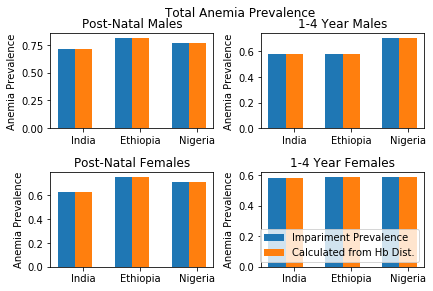

In [121]:
# validation of cause list with anemia impairment prev
# these should be equal
# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = total_anemia['val'].where(total_anemia['age_group_id'] == 4).where(total_anemia['sex_id'] == 1).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = total_anemia['val'].where(total_anemia['age_group_id'] == 5).where(total_anemia['sex_id'] == 1).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = total_anemia['val'].where(total_anemia['age_group_id'] == 4).where(total_anemia['sex_id'] == 2).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = total_anemia['val'].where(total_anemia['age_group_id'] == 5).where(total_anemia['sex_id'] == 2).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Total Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()

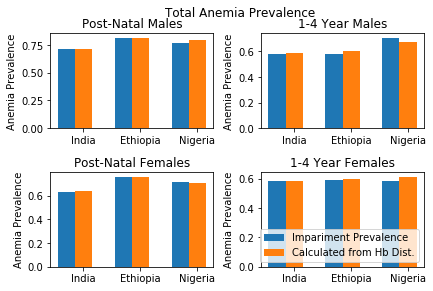

In [122]:
# total anemia (using anemia impairment prevalence)


# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = merged['prev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Total Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()

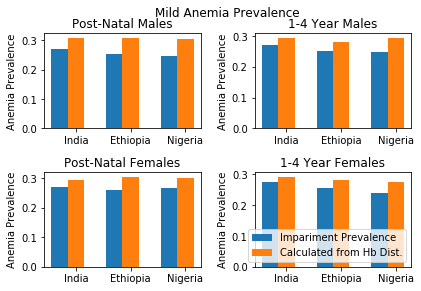

In [123]:
# MILD ANEMIA


# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = mild_anemia['val'].where(mild_anemia['age_group_id'] == 4).where(mild_anemia['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = mild_anemia['val'].where(mild_anemia['age_group_id'] == 5).where(mild_anemia['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = mild_anemia['val'].where(mild_anemia['age_group_id'] == 4).where(mild_anemia['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev_mild'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = mild_anemia['val'].where(mild_anemia['age_group_id'] == 5).where(mild_anemia['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Mild Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()

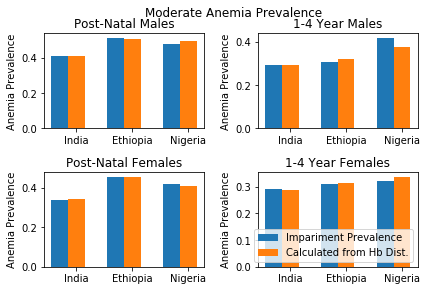

In [124]:
# MODERATE ANEMIA

# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = moderate_anemia['val'].where(moderate_anemia['age_group_id'] == 4).where(moderate_anemia['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = moderate_anemia['val'].where(moderate_anemia['age_group_id'] == 5).where(moderate_anemia['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = moderate_anemia['val'].where(moderate_anemia['age_group_id'] == 4).where(moderate_anemia['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev_mod'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = moderate_anemia['val'].where(moderate_anemia['age_group_id'] == 5).where(moderate_anemia['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Moderate Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()

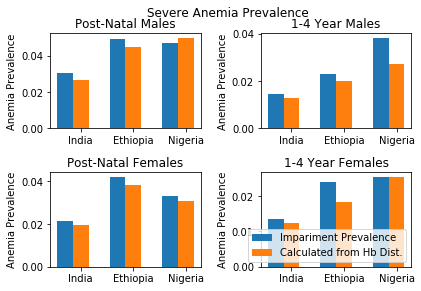

In [125]:
#SEVERE ANEMIA

# bar width
barWidth = 0.3

fig,axs = plt.subplots(2,2)

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 1).dropna()
gbd = severe_anemia['val'].where(severe_anemia['age_group_id'] == 4).where(severe_anemia['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Post-Natal Males')

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 1).dropna()
gbd = severe_anemia['val'].where(severe_anemia['age_group_id'] == 5).where(severe_anemia['sex_id'] == 1).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('1-4 Year Males')

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 4).where(merged['sex_id'] == 2).dropna()
gbd = severe_anemia['val'].where(severe_anemia['age_group_id'] == 4).where(severe_anemia['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('Post-Natal Females')

model = merged['ensemble_dist_prev_sev'].where(merged['age_group_id'] == 5).where(merged['sex_id'] == 2).dropna()
gbd = severe_anemia['val'].where(severe_anemia['age_group_id'] == 5).where(severe_anemia['sex_id'] == 2).dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Year Females')


plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=['India','Ethiopia','Nigeria'])

for ax in axs.flat:
    ax.set(ylabel='Anemia Prevalence')

plt.legend(['Impariment Prevalence','Calculated from Hb Dist.'], loc='lower right')
plt.suptitle('Severe Anemia Prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()